# Counterfactuals

In [72]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(ggridges)
library(sdazar)
library(data.table)
library(MASS)
library(stringr)

# library(bayesplot)
library(forcats)
library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

In [73]:
# load data
df = data.table(read_stata('../data/Ex_LA1850-2013_SES_ABBREVIATED_april-3-2018.dta'))

In [74]:
country_labels = c("Argentina", "Bolivia", "Brazil", "Chile", "Colombia", 
                   "Costa Rica", "Cuba", "Dominican Republic", "Ecuador", 
                   "El Salvador", "Guatemala", "Honduras", "Mexico", "Nicaragua", 
                   "Panama", "Paraguay", "Peru", "Uruguay", "Venezuela")

In [75]:
df[, ctry := factor(ctry, labels=country_labels)]

In [76]:
# intrapolation?
# x <- 1:10
# y <- rnorm(10)

# plot(x, y, main = "approx(.) and approxfun(.)")
# # points(approx(x, y), col = 2, pch = "*")
# points(approx(y, method = "linear"), col = 4, pch = "*")

In [77]:
male = df[tseries2==1 & sex==1 & age==0]

male = male[complete.cases(male[, .(Ex, gdp_pc)])]

male = male[, .(ctry, year, gdp_pc, Ex)]
setnames(male, c('gdp_pc', 'Ex'), c('gdp', 'le'))

In [78]:
male[, le_log := scale(log(le), scale=FALSE)]
male[, gdp_log := scale(log(gdp), scale=FALSE)]
male[, year_log := scale(log(year), scale=FALSE)]

In [79]:
# year recode based on the criteria proposed by Alberto
male[year<1950, gyear:=1]
male[year>=1950 & year<1970, gyear:=2]
male[year>=1970 & year<1990, gyear:=3]
male[year>=1990, gyear :=4]
male[, gyear := factor(gyear, levels=1:4, labels=c('1950', '1950-1969', '1970-1989', '1990'))]

In [80]:
# transform variable: weibull
male[, y := le/max(le+1.05), by = ctry] # adjustment is by country!
male[, wy := log(-log(1-y))]

In [125]:
max_le = male[, .(max_le = max(le+1.05)), by = ctry]

In [82]:
# function
get_orig_values_weibull = function(x, max_value) { 
    return ( (1 - exp(-exp(x))) * max_value )
}

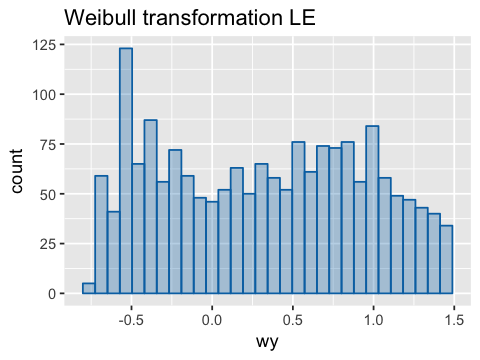

In [83]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(male, aes(wy)) +
    geom_histogram(bins=30, color='#0072B2', fill='#0072B2', alpha=0.3) +
    labs(title='Weibull transformation LE')

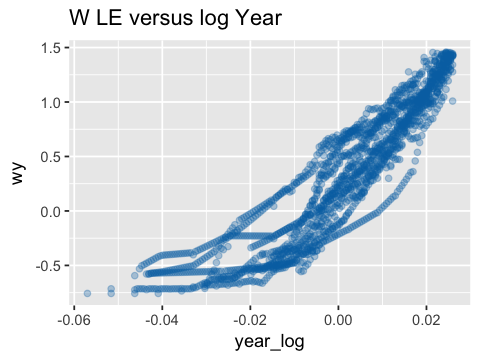

In [84]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(male, aes(y=wy, x=year_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log Year')

This looks very deterministic!

In [85]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(male, aes(y=wy, x=gdp_log)) + geom_point(alpha=0.3, color='#0072B2') +
    labs(title='W LE versus log GDP')

In [112]:
male[ctry=='Cuba' & gyear=='1950-1969']

ctry,year,gdp,le,le_log,gdp_log,year_log,gyear,y,wy,ctry_year
Cuba,1950,2046.226,57.62173,0.1452135,-0.2861650,-0.0043660498,1950-1969,0.7520193,0.3324673,Cuba.1950-1969
Cuba,1951,2175.567,58.04345,0.1525055,-0.2248726,-0.0038533607,1950-1969,0.7575231,0.3484352,Cuba.1950-1969
Cuba,1952,2206.633,59.88000,0.1836563,-0.2106944,-0.0033409344,1950-1969,0.7814919,0.4193234,Cuba.1950-1969
Cuba,1953,1900.373,59.57010,0.1784674,-0.3601119,-0.0028287704,1950-1969,0.7774473,0.4071912,Cuba.1950-1969
Cuba,1954,1956.722,60.33599,0.1912426,-0.3308913,-0.0023168687,1950-1969,0.7874430,0.4373160,Cuba.1950-1969
Cuba,1955,2004.982,60.80935,0.1990573,-0.3065271,-0.0018052289,1950-1969,0.7936208,0.4561835,Cuba.1950-1969
Cuba,1956,2144.501,61.80196,0.2152489,-0.2392552,-0.0012938507,1950-1969,0.8065754,0.4964431,Cuba.1950-1969
Cuba,1957,2406.354,62.17276,0.2212306,-0.1240493,-0.0007827339,1950-1969,0.8114146,0.5117477,Cuba.1950-1969
Cuba,1958,2362.836,62.80854,0.2314048,-0.1422992,-0.0002718782,1950-1969,0.8197122,0.5383633,Cuba.1950-1969
Cuba,1959,2066.836,63.17926,0.2372898,-0.2761431,0.0002387166,1950-1969,0.8245504,0.5541170,Cuba.1950-1969


### Counterfactuals

- I create a variable resulting from the combination of country and year
- I specify country-year random intercept and GDP random coefficient

In [86]:
# check sample sizes
male[, ctry_year := interaction(ctry, gyear)]
table(male$ctry_year)


              Argentina.1950                 Bolivia.1950 
                          76                            5 
                 Brazil.1950                   Chile.1950 
                          78                           81 
               Colombia.1950              Costa Rica.1950 
                          45                           30 
                   Cuba.1950      Dominican Republic.1950 
                          29                            0 
                Ecuador.1950             El Salvador.1950 
                           0                           20 
              Guatemala.1950                Honduras.1950 
                          30                           20 
                 Mexico.1950               Nicaragua.1950 
                          51                           10 
                 Panama.1950                Paraguay.1950 
                           5                            0 
                   Peru.1950                 Uruguay.19

In [87]:
m1 = brm(formula = wy ~ 1 + gdp_log +  (gdp_log|ctry_year), 
    data = male)

Compiling the C++ model
Start sampling


In [89]:
summary(m1)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: wy ~ 1 + gdp_log + (gdp_log | ctry_year) 
   Data: male (Number of observations: 1772) 
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1; 
         total post-warmup samples = 4000
    ICs: LOO = NA; WAIC = NA; R2 = NA
 
Group-Level Effects: 
~ctry_year (Number of levels: 73) 
                       Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sd(Intercept)              0.56      0.06     0.46     0.68        578 1.01
sd(gdp_log)                0.69      0.07     0.57     0.84       1340 1.00
cor(Intercept,gdp_log)    -0.01      0.13    -0.27     0.24        615 1.00

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept     0.38      0.07     0.25     0.52        331 1.02
gdp_log       0.74      0.09     0.57     0.91        684 1.00

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     0.10      0.00 

### Examine GOF

In [127]:
pred = cbind(male[, .(ctry, year, le, gdp_log, le_log)], predict(m1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [128]:
pred = merge(pred, max_le, by = 'ctry')

In [132]:
pred

ctry,year,le,gdp_log,le_log,m,Est.Error,lo,hi,max_le
Argentina,1870,30.75355,-0.618525696,-0.4826808,26.30572,0.10668585,22.10229,31.00869,72.47509
Argentina,1875,31.10049,-0.510278662,-0.4714628,28.33749,0.10493131,24.09336,33.09579,72.47509
Argentina,1876,31.17035,-0.508824633,-0.4692190,28.36099,0.10465959,24.06736,33.00388,72.47509
Argentina,1877,31.24038,-0.431519681,-0.4669749,29.88217,0.10584345,25.30557,34.82582,72.47509
Argentina,1878,31.31056,-0.505386839,-0.4647308,28.45194,0.10579944,24.06866,33.37517,72.47509
Argentina,1879,31.38091,-0.488454078,-0.4624866,28.74189,0.10553581,24.29129,33.59637,72.47509
Argentina,1880,31.45141,-0.529407331,-0.4602423,27.97803,0.10765746,23.47628,32.75910,72.47509
Argentina,1881,31.52208,-0.535633099,-0.4579981,27.89592,0.10746897,23.62897,32.84833,72.47509
Argentina,1882,31.58878,-0.334200106,-0.4558843,31.92842,0.10276180,27.32389,37.11567,72.47509
Argentina,1883,31.69156,-0.252804216,-0.4526360,33.68350,0.10341082,28.91061,38.90189,72.47509


In [129]:
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_value_le), 
    lo = get_orig_values_weibull(lo, max_value_le),
    hi = get_orig_values_weibull(hi, max_value_le)
    )]

In [130]:
max_ex = max(male$le)+25.0
min_ex = min(male$le)-25.0
max_year = max(male$year)
min_year = min(male$year)

plots = list()
for (c in country_labels) {

assign(paste0('plot', which(country_labels == c)), ggplot(pred[ctry==c], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=0.3, color='#e34a33', alpha=0.4) +
    labs(title=c) + 
        ylim(min_ex, max_ex) + 
        xlim(min_year, max_year) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted')
       )
    
    }

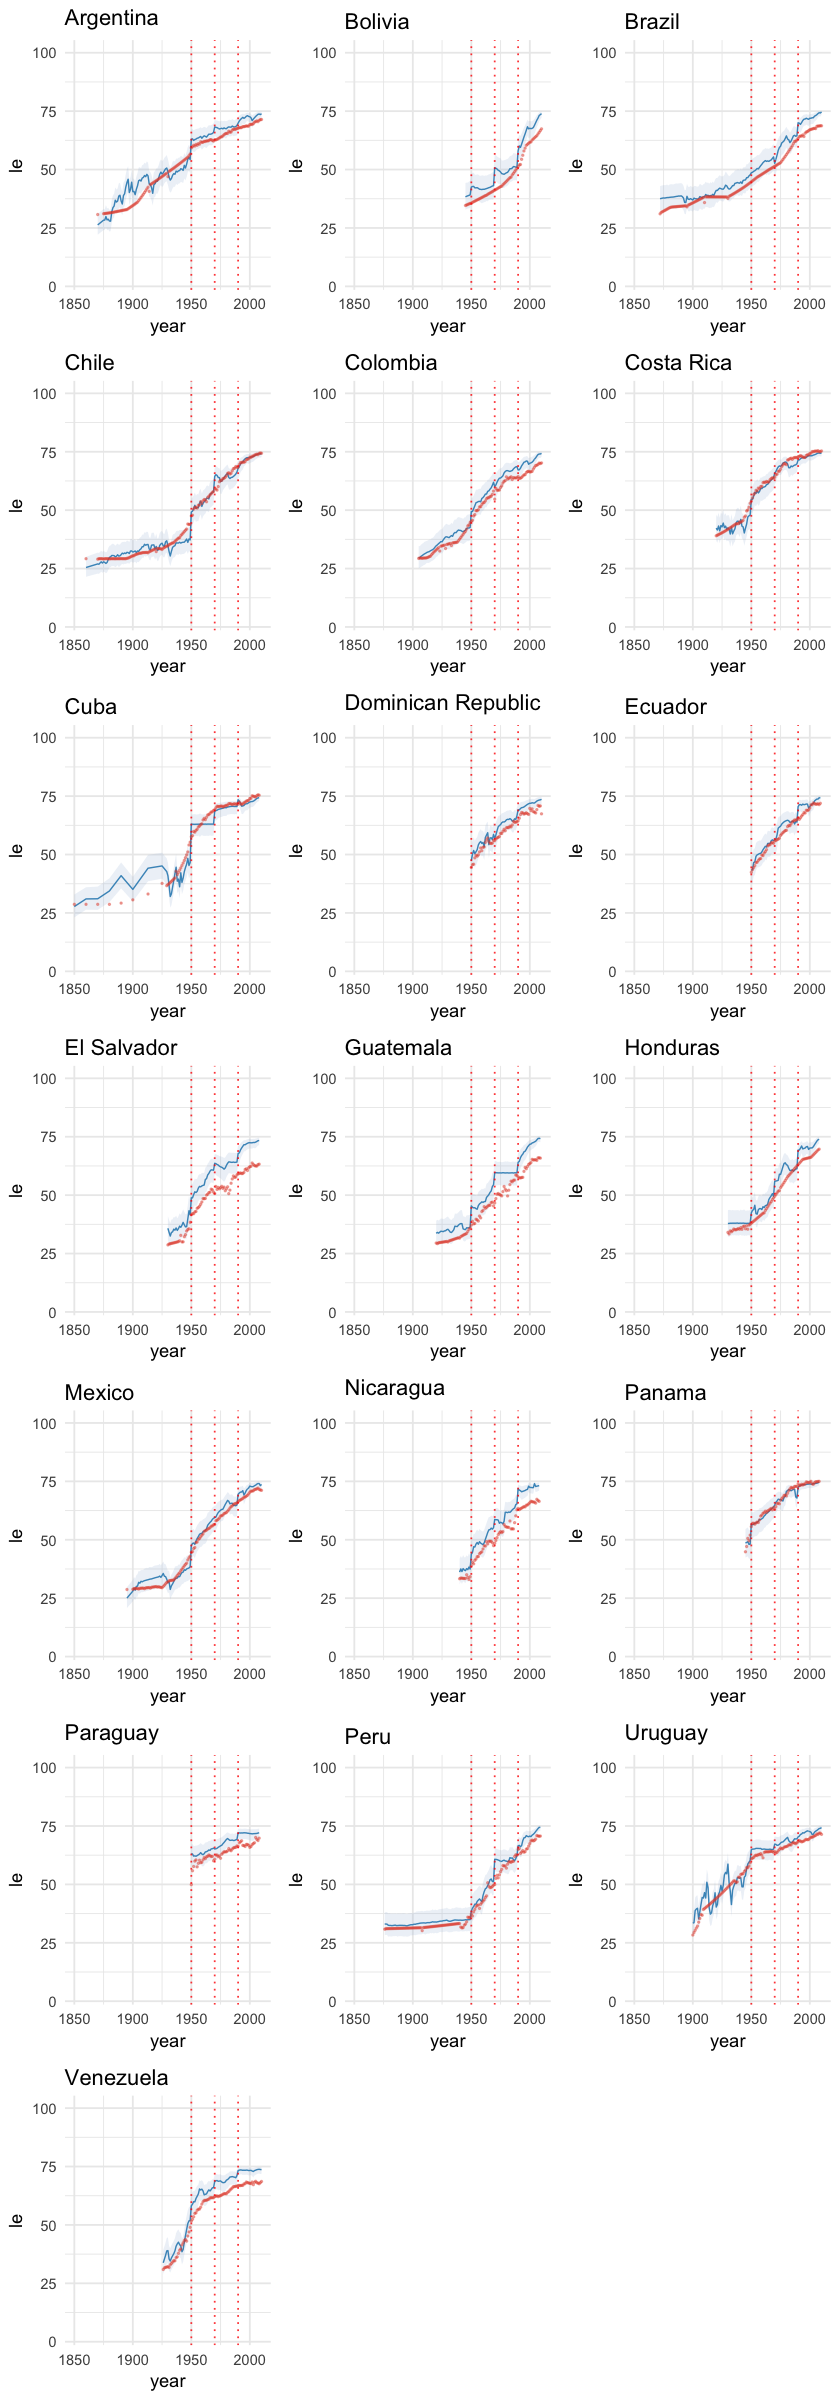

In [131]:
options(repr.plot.width = 7, repr.plot.height = 20)
eval(parse(text=paste0(paste0('plot', 1:length(country_labels), collapse='+'), '+ plot_layout(ncol = 3)')))

# STOP HERE!

### Counterfactuals 2020

In [115]:
# extract posterior samples of population-level effects 
samples <- posterior_samples(m1)

In [119]:
summary(samples[, 'r_ctry_year[Cuba.1950-1969,gdp_log]'])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.7679 -0.9673 -0.7345 -0.7379 -0.5122  0.4876 

In [18]:
years = c(1950, 1970, 1990, 2010)

gdp_values = df[ctry==2020 & year %in% years, gdp_log]
le_values = df[ctry==2020 & year %in% years, le]

In [19]:
# function to estimate shifts
estimate_shift = function(samples, country=NULL, 
                          model_year=NULL,
                          le_value=NULL,
                          gdp_value = NULL, 
                          max_le_value = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {

    colnames = names(samples)
    betas = paste0('b_', coefficients)
    
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))
    s = samples[, c(betas, random)]
    pp = s[,1] + s[,3] + (s[,2] + s[,4]) * gdp_value
    pg = unlist(sapply(pred, function(x) 
            get_orig_values_weibull(x, max_value=max_le_value)))
        
     return(le_value-pg)
}

In [62]:
pred = list()
lyears = c('1950', '1950-1969', '1970-1989', '1990')

for (i in lyears) {

    pred[[i]] = estimate_shift(samples, country='2020',
                         model_year=i,
                         gdp_value = gdp_values[1],
                         le_value = le_values[1],
                         max_le_value=max_le[ctry==2020, max_le])
    
}

In [63]:
d = melt(data.frame(pred))

No id variables; using all as measure variables


In [142]:
l = unique(d$variable)
year_labels = c('<1950', '1950-1969', '1970-1989', '>=1990')
d$variable = factor(d$variable, levels=rev(l), labels=rev(year_labels))

Picking joint bandwidth of 0.401


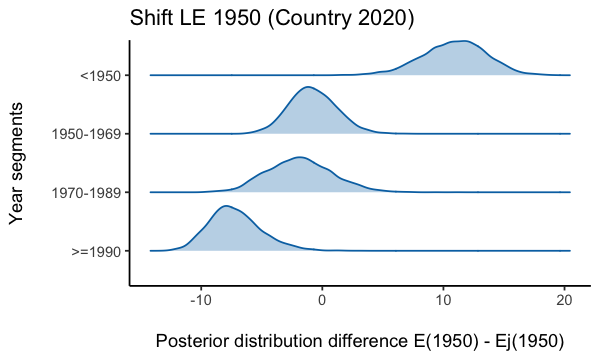

In [143]:
p = ggplot(d, aes(y=variable)) +
      geom_density_ridges(aes(x = value),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1950) - Ej(1950)', 
          y='Year segments\n', title='Shift LE 1950 (Country 2020)') + 
      theme_classic()
print(p)

### Counterfactuals 2070

In [164]:
pred = cbind(df[, .(ctry, year, le, year_log, gdp_log, le_log)], predict(w1))
setnames(pred, c('Estimate', '2.5%ile', '97.5%ile'), c('m', 'lo', 'hi'))

In [165]:
max_value_le = max_le[ctry==2070, max_le]

In [166]:
pred = merge(pred, max_le, by = 'ctry')
pred[,  `:=` (
    m = get_orig_values_weibull(m, max_value_le), 
    lo = get_orig_values_weibull(lo, max_value_le),
    hi = get_orig_values_weibull(hi, max_value_le)
    )]

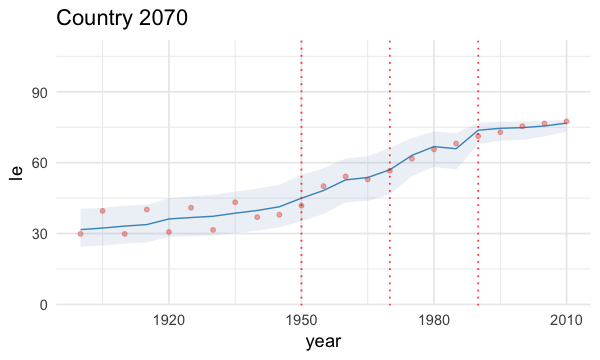

In [167]:
ggplot(pred[ctry==2070], aes(x=year, y=le)) + 
    geom_line(aes(y=m), color='#2b8cbe', size = 0.4)  +
    geom_ribbon(aes(ymin = lo, ymax = hi), fill = '#a6bddb', alpha=0.2)  + 
    geom_point(size=1, color='#e34a33', alpha=0.4) +
    labs(title=paste0('Country ', '2070')) + 
        ylim(min(df$le)-25.0, max(df$le)+25.0) + 
        xlim(min(df$year), max(df$year)) + theme_minimal() + 
    geom_vline(xintercept = 1950, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1970, size=0.5, color='red', alpha=0.8, linetype = 'dotted') +
    geom_vline(xintercept = 1990, size=0.5, color='red', alpha=0.8, linetype = 'dotted') 

In [168]:
pred = list()
lyears = c('1950', '1950-1969', '1970-1989', '1990')

for (i in lyears) {

    pred[[i]] = estimate_shift(samples, country=2070,
                         model_year=i,
                         gdp_value = gdp_values[1],
                         le_value = le_values[1],
                         max_le_value=max_le[ctry==2070, max_le])
    
}

In [169]:
d = melt(data.frame(pred))

No id variables; using all as measure variables


In [170]:
l = unique(d$variable)
year_labels = c('<1950', '1950-1969', '1970-1989', '>=1990')
d$variable = factor(d$variable, levels=rev(l), labels=rev(year_labels))

Picking joint bandwidth of 0.596


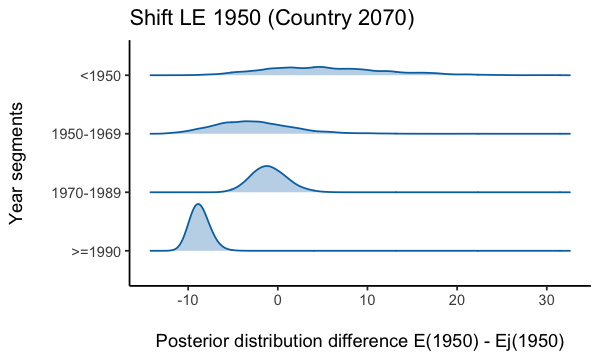

In [171]:
p = ggplot(d, aes(y=variable)) +
      geom_density_ridges(aes(x = value),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1950) - Ej(1950)', 
          y='Year segments\n', title='Shift LE 1950 (Country 2070)') + 
      theme_classic()
print(p)

# Create all shifts (country and years)

In [109]:
estimate_shift = function(samples, country=NULL, 
                          model_year=NULL,
                          le_value=NULL,
                          gdp_value = NULL, 
                          max_le_value = NULL,
                          coefficients = c('Intercept', 'gdp_log')) {
    
    colnames = names(samples)
    betas = paste0('b_', coefficients)
    
    random = str_subset(colnames, paste0('^r_.+\\[', country, '.', model_year, ','))
    s = samples[, c(betas, random)]
    pp = s[,1] + s[,3] + (s[,2] + s[,4]) * gdp_value
    pg = unlist(sapply(pp, function(x) 
            get_orig_values_weibull(x, max_value=max_le_value)))
        
     return(le_value-pg)
}

In [58]:
countries = unique(df$ctry)
iyears = c(1950, 1970, 1990, 2010)
model_year = c('1950', '1950-1969', '1970-1989', '1990')

In [149]:
shifts = list()

for (c in countries) {
        
    max_le_value = max_le[ctry==c, max_le]
    years = as.numeric(df[ctry == c & year %in% iyears, year])
    model_years = as.character(unique(df[ctry == c, gyear]))

    for (ys in years) {
        
        for (ysm in model_years) { 
            
            est = estimate_shift(samples, 
                                 country = c, 
                                 model_year = ysm, 
                                 gdp_value = df[ctry==c & year==ys, gdp_log],
                                 le_value =  df[ctry==c & year==ys, le],
                                 max_le_value=max_le_value)
            name = paste0(c(c,ys,ysm), collapse='.')
            shifts[[paste0(c(c,ys,ysm), collapse='.')]] = data.table(name, pred_shift = est)
                                     
          }
    
    }
    
}

In [161]:
shifts = rbindlist(shifts)

shifts[, c('ctry', 'year', 'segment') := tstrsplit(name, ".", fixed=TRUE)]

shifts[, segment := factor(segment, levels=c('1990', '1970-1989', '1950-1969', '1950'), 
                         labels = c('>=1990', '1970-1989', '1950-1969', '<1950')) ]

In [166]:
options(repr.plot.width = 5, repr.plot.height = 3)

Picking joint bandwidth of 0.401


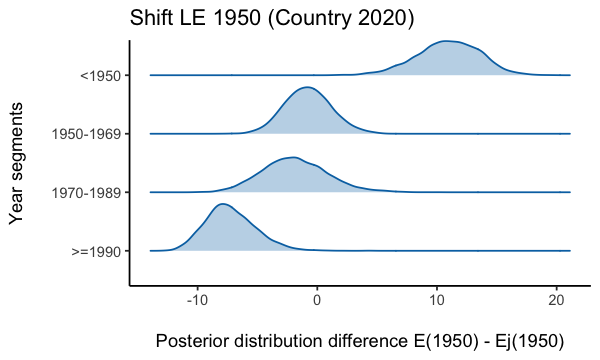

In [170]:
p = ggplot(shifts[year=='1950' & ctry=='2020', ], aes(y=segment)) +
      geom_density_ridges(aes(x=pred_shift),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1950) - Ej(1950)', 
          y='Year segments\n', title='Shift LE 1950 (Country 2020)') + 
      theme_classic()
print(p)

Picking joint bandwidth of 0.37


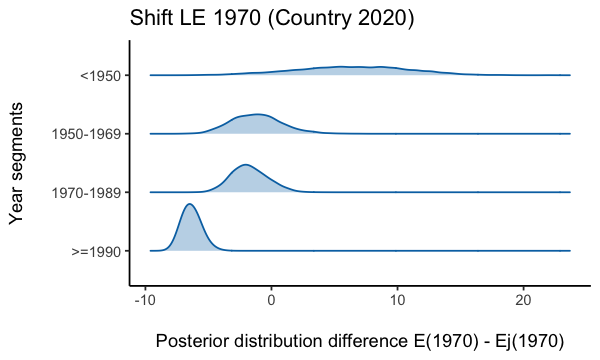

In [169]:
p = ggplot(shifts[year=='1970' & ctry=='2020', ], aes(y=segment)) +
      geom_density_ridges(aes(x=pred_shift),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1970) - Ej(1970)', 
          y='Year segments\n', title='Shift LE 1970 (Country 2020)') + 
      theme_classic()
print(p)

Picking joint bandwidth of 0.367


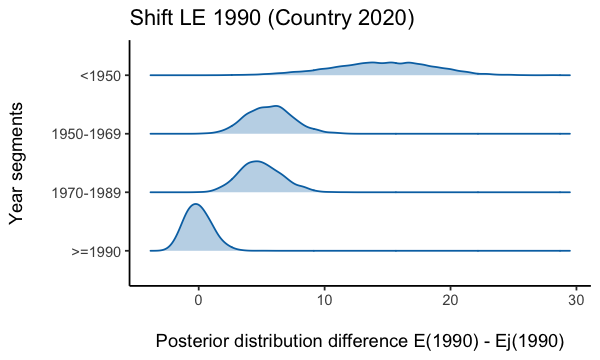

In [167]:
p = ggplot(shifts[year=='1990' & ctry=='2020', ], aes(y=segment)) +
      geom_density_ridges(aes(x=pred_shift),
               alpha=0.3, color='#0072B2', fill='#0072B2', scale=0.8) +
      labs(x='\nPosterior distribution difference E(1990) - Ej(1990)', 
          y='Year segments\n', title='Shift LE 1990 (Country 2020)') + 
      theme_classic()
print(p)